In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv("S02-hw-dataset.csv")
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


In [20]:
# Пропуски
print(df.isna().mean())

# Дубликаты
print("Дубликаты:", df.duplicated().sum())

# 1. Отрицательные где их быть недолжно
negative_values = df[(df['purchases'] < 0) | (df['revenue'] < 0) ]
print("Отрицательные значения в purchases или revenue")
print(negative_values)

# 2. Нереалистичный возраст
suspicious_age = df[(df['age'] < 0) | (df['age'] > 100)]
print("\nПодозрительный возраст")
print(suspicious_age)

# 3. Логические противоречия между purchases и revenue
inconsistent = df[
    ((df['purchases'] == 0) & (df['revenue'] != 0)) |
    ((df['purchases'] > 0) & (df['revenue'] == 0))
]
print("\nПротиворечия: нулевой доход при ненулевых количествах и наоборот")
print(inconsistent)

# 4. Дубликаты по user_id (не полные дубликаты строк, а повторы ID)
duplicate_user_ids = df[df.duplicated(subset=['user_id'], keep=False)]
print("\nПовторяющиеся user_id (дубли)")
print(duplicate_user_ids)



user_id      0.00000
age          0.04878
country      0.00000
purchases    0.00000
revenue      0.00000
dtype: float64
Дубликаты: 1
Отрицательные значения в purchases или revenue
   user_id    age country  purchases  revenue
5        6  120.0      FR         -1      785

Подозрительный возраст
   user_id    age country  purchases  revenue
5        6  120.0      FR         -1      785

Противоречия: нулевой доход при ненулевых количествах и наоборот
    user_id   age country  purchases  revenue
10       11  24.0      US          4        0

Повторяющиеся user_id (дубли)
    user_id   age country  purchases  revenue
9        10  24.0      RU          7      511
40       10  24.0      RU          7      511


1.Ошибка значения возраста: в данных присутствуют пользователи с возрастом 5 лет и 120 лет, что нереалистично, если это какой то сервис.

2.Некорректные данные: у пользователя с id=6 указано -1 покупок - это ошибка, потому что количество покупок не может быть отрицательным.

3.Логические противоречия: у пользователя с id=11 сделано 4 покупки, но общая выручка равна 0, это не логично: если были покупки, должна быть и выручка.

4.Дублирование записей: пользователь с id=10 продублирован в датасете дважды с одинаковыми данными, это тоже ошибка.

In [21]:
# Частоты по странам
country_freq = df['country'].value_counts()
print("Частота пользователей по странам:")
print(country_freq)

# Группировка по странам: средняя и общая выручка, средние покупки
grouped = df.groupby('country').agg(
    total_revenue=('revenue', 'sum'),
    avg_revenue=('revenue', 'mean'),
    avg_purchases=('purchases', 'mean'),
    user_count=('user_id', 'count')
).round(2)

print("Агрегированные метрики по странам:")
grouped

Частота пользователей по странам:
country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64
Агрегированные метрики по странам:


,total_revenue,avg_revenue,avg_purchases,user_count
country,,,,
CN,2108,1054.00,4.50,2
DE,8673,1445.50,6.50,6
FR,8111,675.92,4.25,12
RU,10271,790.08,4.77,13
US,4459,557.38,4.62,8


1.По количеству пользователей лидируют Россия и Франция.

2.У Германии самая большая выручка, хотя небольшое число клиентов. Скорее всего они делают дорогие покупки.

3.Несмотря на большое количество пользователей из RU, их средняя выручка ниже, чем у пользователей из DE или CN. Также есть случаи, когда пользователи с большим числом покупок (purchases=7, user_id=1) имеют относительно низкую выручку (749), что может говорить о низкой цене товаров или наличии скидок.

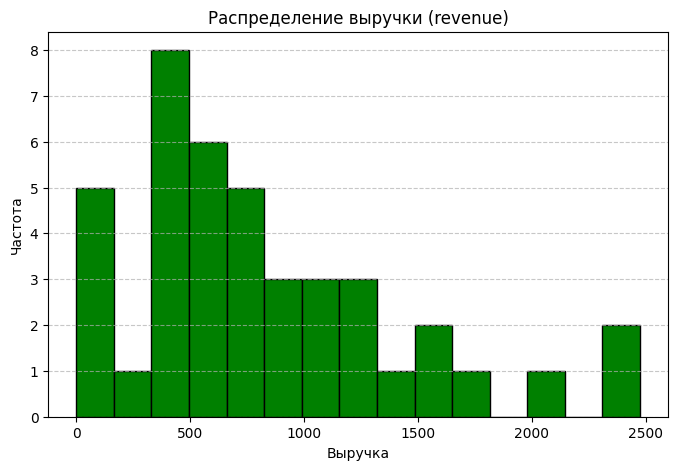

In [22]:
plt.figure(figsize=(8, 5))
plt.hist(df['revenue'], bins=15, color='green', edgecolor='black')
plt.title('Распределение выручки (revenue)')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("figures/revenue_hist.png", dpi=150, bbox_inches='tight')
plt.show()

На графике - распределение значений выручки по всем пользователям.

Большинство пользователей генерируют выручку в диапазоне от 0 до 1000, что является нормой. Однако есть показатель с высокими значениями (до 2500), что указывает на наличие пользователей, которые тратят больше остальных.

<Figure size 1000x600 with 0 Axes>

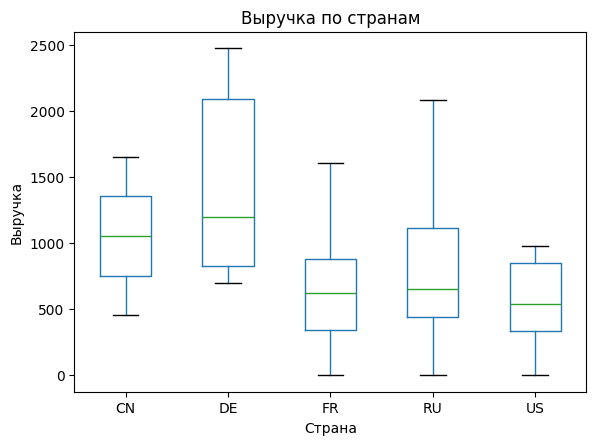

In [23]:
plt.figure(figsize=(10, 6))
df.boxplot(column='revenue', by='country', grid=False)
plt.title('Выручка по странам')
plt.suptitle('')  # убираем автоматический заголовок от pandas
plt.xlabel('Страна')
plt.ylabel('Выручка')
plt.savefig("figures/revenue_boxplot.png", dpi=150, bbox_inches='tight')
plt.show()

Распределение выручки внутри каждой страны (CN, DE, FR, RU, US).

Страна DE имеет самый высокий уровень выручки и большой разброс. У стран FR и RU медиана выручки ниже, а у US — самый низкий. Нет статистических выбросов, даже самые большие суммы выручки не являются аномалиями в рамках этого небольшого датасета.



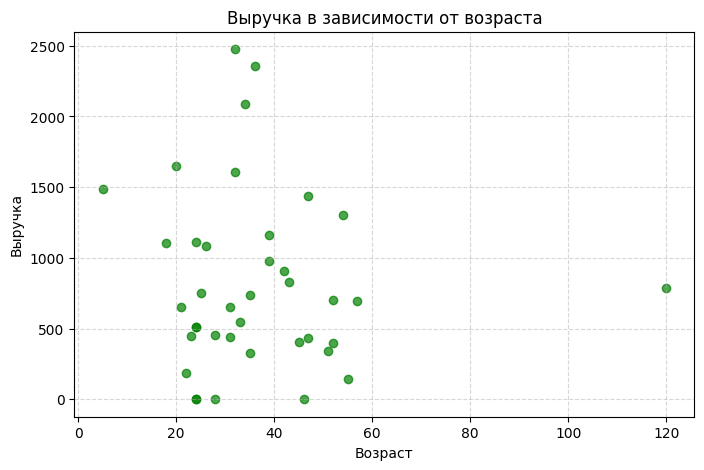

In [24]:
plt.figure(figsize=(8, 5))
plt.scatter(df['age'], df['revenue'], alpha=0.7, c='green')
plt.title('Выручка в зависимости от возраста')
plt.xlabel('Возраст')
plt.ylabel('Выручка')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("figures/age_revenue_scatter.png", dpi=150, bbox_inches='tight')
plt.show()

Зависимость выручки от возраста пользователя.

Пользователи разных возрастов могут иметь как низкую, так и высокую выручку. Однако стоит обратить внимание на выбросы: например, пользователь в возрасте 120 лет с высокой выручкой — это либо ошибка, либо долгожитель (уникальный случай). Также видно, что самые большие суммы выручки приходятся на возрастной диапазон 20–50 лет, что соответствует реальности.